## Projeto 1

Este trabalho compara a eficiência e eficácia de múltiplos algoritmos de Aprendizado por Reforço (RL), sendo eles MonteCarlo, Sarsa(Lambda) e Q_learning, em diferentes cenários e variando seus parâmetros quando necessário. O ambiente/problema que foi usado como teste são labirintos, onde os algoritmos precisam encontrar uma politica ótima para que o agente consiga chegar até o final do labirinto. O algoritmo DQN (Deep Q Networking) também foi implementado, porém utilizando outro ambiente, análogo ao nosso. Importante citar que o que chamamos de política ótima neste trabalho se refere a capacidade dessa política de levar o agente até o objetivo, na menor quantidade de passos.


### Ambiente
Como dito anteriormente, os ambientes são labirintos. Eles são descritos por meio de arquivos .txt, onde são apontados as paredes, caminhos, estados terminais, formato e suas recompensas. Os arquivos têm essa cara:
```
4 4
. path -1
@ agent -1
$ goal 100
# wall -1000
######
#...$#
#@...#
######
```

A primeira linha contém dois inteiros E e L, que representam o número de elementos e o número de linhas do labirinto. Em seguida são descritos os símbolos que compõem os elementos. Os caminhos são representados pelo caractere '.' e possuem recompensa de -1. O agente é representado pelo ‘@’. Por sua vez, o estado terminal, ou objetivo, é representado por '$' e possui recompensa de 100.Por fim, as paredes são representadas por ‘#’. Após a descrição dos símbolos, há a descrição do próprio formato do labirinto.

Diferentes formatos de labirintos foram adotados para o trabalho, sendo alguns mais amplos, outros com diversos caminhos até o objetivo, e outros com caminhos extremamente estreitos.

### Código
As primeiras células desse notebook contém o código usado para implementação e obtenção dos resultados. Porém, para facilitar, foram geradas imagens com os resultados obtidos (usando [pygame](https://www.pygame.org/)), e a análise foi feita em cima delas. O código está disponível para execução, alteração, e teste de outras configurações de labirinto.

### Métricas
Para comparação dos algoritmos entre si, foram extraídas as recompensas médias e o tamanho do caminho percorrido a partir de um mesmo ponto do mapa definido na criação do mapa pelo valor 'agent', neste caso o '@'. Com isso é possível analisar o quão eficiente foi o caminho encontrado pelo algoritmo, caso encontrado, e se ele conseguiu convergir. Há também a análise de desempenho e custo computacional, o <b style="color:#770000">número médio de episódios para convergência</b>, o <b style="color:#770000">tempo de convergência</b>, os <b style="color:#770000">hiperparametros</b> necessários para ajustar o algoritmo, e o quão <b style="color:#770000">difícil</b> foi encontrar um valor ótimo.

Além disso, um mapa de calor gerado a partir da função valor será usado para ilustrar o quão bom é estar em cada estado, ou seja, em cada posição do labirinto. Também será mostrado um gráfico contendo as recompensas do modelo ao longo do tempo, para que seja possível analisar o quão rápido o algoritmo convergiu. Esse gráfico utiliza o recurso da média móvel para suavizar os dados e facilitar a visualização e compreensão.




# Códigos:

In [19]:
import numpy as np
from itertools import product
import random
from threading import Thread
import time
from argparse import ArgumentParser
import matplotlib.pyplot as plt
import numpy as np
import time
import pygame

In [20]:
class Renderer():
    def __init__(self, chief, content, title=None, dimensions=(800, 800)):
        self.chief = chief
        self.content = content
        self.contents = [content] # para trocar entre janelas
        self.iConteudoAtual = 0 # para marcar qual o atual dentre os varios
        self.title = title
        self.dimensions = dimensions
        self.running = True
        if not self.title:
            self.title = type(chief).__name__   # title é o nome da classe
        
        
        # redimensiona o ambiente para caber na tela
        self.tamanhosprite = 64
        self.escala = (self.dimensions[0]/len(self.content[0]), self.dimensions[1]/len(self.content))
        while self.escala[0] < self.tamanhosprite//8 or self.escala[1] < self.tamanhosprite//8: # redimensiona pra pp
            self.dimensions =(int(self.dimensions[0] *1.1), int(self.dimensions[1]*1.1))
            self.escala = (self.dimensions[0]/len(self.content[0]), self.dimensions[1]/len(self.content))

        self.load_sprites()

        # cria uma thread que roda o pygame
        displayer = Thread(target=self.show) # shower = mostrador

        # Inicia a thread
        displayer.start()

    def addConteudo(self,conteudo):
        self.contents.append(conteudo)

    def desligar(self):
        self.running = False

    def load_sprites(self):
        self.sprites = dict()
        self.sprites["path"] = pygame.transform.scale(pygame.image.load("imgs/path.png"), (int(self.escala[0]), int(self.escala[1])))
        self.sprites["wall"] = pygame.transform.scale(pygame.image.load("imgs/wall.png"), (int(self.escala[0]), int(self.escala[1])))
        self.sprites["goal"] = pygame.transform.scale(pygame.image.load("imgs/goal.png"), (int(self.escala[0]), int(self.escala[1])))
        self.sprites["cookie"] = pygame.transform.scale(pygame.image.load("imgs/cookie.png"), (int(self.escala[0]), int(self.escala[1])))
        self.sprites["agent"] = pygame.transform.scale(pygame.image.load("imgs/agent.png"), (int(self.escala[0]), int(self.escala[1])))
        self.sprites["right"] = pygame.transform.scale(pygame.image.load("imgs/right.png"), (int(self.escala[0]), int(self.escala[1])))
        self.sprites["up"] = pygame.transform.scale(pygame.image.load("imgs/up.png"), (int(self.escala[0]), int(self.escala[1])))
        self.sprites["left"] = pygame.transform.scale(pygame.image.load("imgs/left.png"), (int(self.escala[0]), int(self.escala[1])))
        self.sprites["down"] = pygame.transform.scale(pygame.image.load("imgs/down.png"), (int(self.escala[0]), int(self.escala[1])))
        self.sprites["acid"] = pygame.transform.scale(pygame.image.load("imgs/acid.png"), (int(self.escala[0]), int(self.escala[1])))
        self.sprites["lava"] = pygame.transform.scale(pygame.image.load("imgs/lava.png"), (int(self.escala[0]), int(self.escala[1])))


        self.asciiSprites = dict()
        self.asciiSprites["path"]   = '⬛'
        self.asciiSprites["wall"]   = '🧱'
        self.asciiSprites["goal"]   = '⚽'
        self.asciiSprites["cookie"]   = '🍪'
        self.asciiSprites["agent"]  = '👾' 
        self.asciiSprites["right"]  = '->' #'➡️'
        self.asciiSprites["up"]     = '⬆️⬆️'
        self.asciiSprites["left"]   = '<-' 
        self.asciiSprites["down"]   = '⬇️⬇️'
        self.asciiSprites["lava"]   = '🌋'
        self.asciiSprites["acid"]   = '🦠'

    def create_heatmap(data, cmap='viridis', title='Heatmap'):
        """
        Create a heatmap from a list of lists of floats.

        Parameters:
        - data: List of lists of floats representing the heatmap data.
        - cmap: Colormap for the heatmap (default is 'viridis').
        - title: Title for the heatmap (default is 'Heatmap').
        """
        data = np.array(data, dtype=float)

        # Create a figure and axis
        fig, ax = plt.subplots()

        # Display the heatmap using imshow
        im = ax.imshow(data, cmap=cmap)

        # Add a colorbar to the right of the heatmap
        cbar = ax.figure.colorbar(im, ax=ax)

        # Set the title
        ax.set_title(title)

        # Show the plot
        plt.show()

    def showAscii(self):
        for i in range(len(self.content)):
            for j in range(len(self.content[0])):
                cell = self.content[i][j]
                # se o content de cell estiver no dicionario de sprites
                if cell in self.asciiSprites:
                    obj = cell
                else:
                    obj = self.chief.symbols[cell]
                print(self.asciiSprites.get(obj,'❌'),end='')
            print('')

    def show(self):
        # renderiza o ambiente
        pygame.init()
        self.screen = pygame.display.set_mode(self.dimensions)
        pygame.display.set_caption(self.title)
        self.screen.fill((0, 0, 0))

        try:
            while self.running:
                pygame.time.delay(10)  # delay de 10ms
                # Botao de fechar
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        pygame.quit()
                        self.running = False
                    # se apertar "p"
                    if event.type == pygame.KEYDOWN:
                        if event.key == pygame.K_p:
                            self.iConteudoAtual = 1
                            self.content = self.contents[self.iConteudoAtual]

                    if event.type == pygame.KEYUP:
                        if event.key == pygame.K_p:
                            self.iConteudoAtual = 0
                            self.content = self.contents[self.iConteudoAtual]

                # limpa a tela
                self.screen.fill((0,0,0))
                
                # desenha o conteudo
                for k in range(self.iConteudoAtual+1):
                    for i in range(len(self.contents[k])):
                        for j in range(len(self.contents[k][0])):
                            celula = self.contents[k][i][j]
                            # se o conteudo de celula estiver no dicionario de sprites
                            if celula in self.sprites:
                                objeto = celula
                            else:
                                objeto = self.chief.symbols[celula]
                            self.screen.blit(self.sprites[objeto], (j*self.escala[0], i*self.escala[1]))

                # Atualizar a tela
                pygame.display.update()
        except Exception as e:
            pass


    def show_path(self, path):
        for i in range(len(self.content)):
            for j in range(len(self.content[0])):
                cell = self.content[i][j]
                if((i,j) in path.keys()):
                    cell = path[(i,j)]
                # se o content de cell estiver no dicionario de sprites
                if cell in self.asciiSprites:
                    obj = cell
                else:
                    obj = self.chief.symbols[cell]
                print(self.asciiSprites.get(obj,'❌'),end='')
            print('')

In [21]:
class Agent():
    actions = ['up', 'down', 'left', 'right']
    def __init__(self, x, y, environment, gamma = 0.9, display=True):
        self.environment = environment
        self.x = x
        self.y = y
        self.gamma = gamma
        self.display = display

    def action_idx(self, action: str):
        return self.actions.index(action)

    def startQ(self, shape, start_value = float("-inf")):
        """
        livroQ é uma lista de listas de dicionarios,
        ele armazena 
        
        """
        self.livro_Q: list[list[dict]] = []
        for i in range(shape[0]):
            self.livro_Q.append([])
            for _ in range(shape[1]):
                self.livro_Q[i].append(dict())
                for acao in self.actions:
                    self.livro_Q[i][-1][acao] = start_value

    def startV(self, shape):
        """
        livroV é uma lista de listas de dicionarios,
        ele armazena 
        
        """ 
        self.book_V: list[list] = []
        for i in range(shape[0]):
            self.book_V.append([])
            for _ in range(shape[1]):
                
                self.book_V[i].append(float("-inf"))
    
    def startPolicy(self, shape, randomPolicy):
        """
        A policy é uma matriz de caracteres que guarda a acao principal
        a ser tomada ate o momento
        
        """
        self.policy: list[list[str]] = []
        for i in range(shape[0]):
            self.policy.append([])
            for j in range(shape[1]):
                if self.environment.symbols[self.environment.original_map[i][j]] == "wall":
                    self.policy[i].append("wall")
                    continue
                if randomPolicy:
                    self.policy[i].append(random.choice(self.actions))
                else:
                    self.policy[i].append(self.actions[0])
        
        if self.display:
            self.render = self.environment.render.addConteudo(self.policy)

    def startReturns(self, shape):
        """
        returns é uma colecao de pares estado acao guardando um
        dicionario para armazenar o valor maximo de reforcos obtidos,
        o numero de vezes que o par estado acao foi visitado e o ultimo
        episodio em que o par estado acao foi visitado
        """
        self.returns: list[list[dict]] = []
        for i in range(shape[0]):
            self.returns.append([])
            for j in range(shape[1]):
                self.returns[i].append(dict())
                for acao in self.actions:
                    self.returns[i][j][acao] = {"value": 0, "count": 0, "lastEpisode": 0}

    def setEnvironment(self, environment):
        self.environment = environment
    
    def setPos(self, position):
        self.x = position[1]
        self.y = position[0]

    def move(self, action):
        return self.environment.move(self, action)
    
    def get_action(self):
        return self.policy[self.y][self.x]


In [22]:
class LearningStrategy():

    def __init__(self) -> None:
        self.feature_lenght = 15
        self.W = np.random.rand(self.feature_lenght)*2-1

    def train(self, episodes):
        pass

    def get_Q(self, x, y, action, linear_approximation = False):
        if not linear_approximation:
            return self.Q[x,y,action]
        
        terms = self.data_to_features(x,y,action)
        return np.dot(self.W, terms)

    def setup(self, environment, agent):
        self.environment: Environment = environment
        self.agent: Agent = agent
    
    def data_to_features(self, x,y,action):
        x= x/self.environment.get_size()[1]
        y= y/self.environment.get_size()[0]
        action = action/len(self.agent.actions)
        return np.array([x,y,action, x*y, y*action, x*action, x*x, y*y, action*action, np.exp(x), np.exp(y), np.exp(action), np.sin(x), np.sin(y), np.sin(action)])
        
    def show_loss(self, rewards, window_size=None):
        # se não for numpy array, transformar em um
        if not isinstance(rewards, np.ndarray):
            rewards = np.asarray(rewards)

        if window_size is not None:
            # calcular a média móvel
            rewards = np.convolve(rewards, np.ones(window_size), 'valid') / window_size

        # Criar o gráfico
        plt.plot(rewards)
        # Adicionar um título
        plt.title("Gráfico de recompensas")

        # Adicionar um eixo x
        plt.xlabel("Episódio")

        # Adicionar um eixo y
        plt.ylabel("Recompensa")

        # Exibir o gráfico
        plt.show()

    def test(self, display = True):
        shape = self.environment.get_size()
        num_states = min(3000,shape[0]*shape[1])
        success = 0
        tries = len(self.environment.avaliations)
        returns = []
        steps = []
        for avaliation in self.environment.avaliations:
            reward = self.environment.setAgentPos(avaliation[0], avaliation[1])
            step_count = 0
            for _ in range(num_states):
                step_count+=1
                action = self.agent.policy[self.agent.y][self.agent.x]
                R = self.environment.move(self.agent, action)
                reward += R
                if self.environment.in_terminal_state():
                    success+=1
                    break
            steps.append(step_count)
            returns.append(reward)
        if display:
            print(f"Sucesso: {success}/{tries}: {success/tries*100}%")
            print(f"Recompensa média: {np.asarray(returns).mean()}")
            print(f"Steps médio: {np.asarray(steps).mean()}")
        return {"sucesso": round(success/tries*100, 2), "recompensa": round(np.asarray(returns).mean(),2), "steps": round(np.asarray(steps).mean(),2)}
            



class MonteCarlo(LearningStrategy):
    def __init__(self) -> None:
        super().__init__()
        self.episode_R = []
        self.episode_length = []
        self.Q = None
        self.time = []
    
    def train(self, episodes, randomPolicy = True, exploration_chance = 0, appx = True, alpha = 0.003, display = True):
        # Initialize
        begin_training_time = time.time()
        shape = self.environment.get_size()
        self.agent.startPolicy(shape, randomPolicy)
        self.agent.startReturns(shape)
        self.Q = np.zeros((shape[0],shape[1], len(self.agent.actions)))
        self.agent.startV(shape)
        current_exploration_chance = exploration_chance
        rewards = []
        for ep in range(episodes):
            start_time = time.time()
            if display:
                if ep % (episodes//10) == 0:
                    print(f"{ep=}")
                    path = self.path_from((1,1))
                    print('Tamanho do episódio:', len(path))
                    print('Recompensa', sum([i[2] for i in path]))
                    path_dict = {}
                    for s,a,r in path:
                        path_dict[s] = a
                    self.environment.render.show_path(path_dict)
            # escolhe posicao aleatoria valida para o agente
            while True:
                state = (random.randrange(0, shape[0]), random.randrange(0, shape[1]))
                if self.environment.original_map[state[0]][state[1]] in {self.environment.default_symbols["path"], self.environment.default_symbols["goal"]}:
                    break
            # escolhe uma acao diferente da dita pela politica atual
            for _ in range(len(self.agent.actions)*2):    # limite maximo de tentativas
                action = random.choice(self.agent.actions)
                if action != self.agent.policy[state[0]][state[1]]:
                    # se a acao nao te leva para uma parede
                    if self.environment.util(state, action): 
                        break
            else:
                action = self.agent.policy[state[0]][state[1]]
            self.episode(state, action, max_steps= min(3000, shape[1]*shape[0]), exploration_chance = exploration_chance)
            g = 0
            for t in range(len(self.agent.recalls)-1, -1, -1): 
                memory = self.agent.recalls[t]  # memoria = (estado, acao, reforco)
                g = self.agent.gamma*g + memory[2]
                # verifica se o par estado acao ja foi inserido em returns
                if self.agent.returns[memory[0][0]][memory[0][1]][memory[1]]["lastEpisode"] != ep:
                    self.agent.returns[memory[0][0]][memory[0][1]][memory[1]]["lastEpisode"] = ep
                    self.agent.returns[memory[0][0]][memory[0][1]][memory[1]]["value"] += g
                    self.agent.returns[memory[0][0]][memory[0][1]][memory[1]]["count"] += 1
                    media = self.agent.returns[memory[0][0]][memory[0][1]][memory[1]]["value"]/self.agent.returns[memory[0][0]][memory[0][1]][memory[1]]["count"]

                    if(not appx):
                        self.Q[memory[0][0],memory[0][1],self.agent.action_idx(memory[1])] = media
                    else:
                        Q = self.get_Q(memory[0][0],memory[0][1],self.agent.action_idx(memory[1]),appx)
                        # print(f"Q: {Q}")
                        features = self.data_to_features(memory[0][0],memory[0][1],self.agent.action_idx(memory[1]))
                        # print(f"{features[0]=}, {g=}, {Q=}, {self.W[0]=}, {alpha=}, {features[0]*alpha*(g-Q)=}")
                        deltaW = alpha * (g - Q) * features
                        # print(f"deltaW: {deltaW}")
                        self.W += deltaW


                    self.agent.book_V[memory[0][0]][memory[0][1]] = media
                    self.agent.policy[memory[0][0]][memory[0][1]] = max(self.agent.actions, key = lambda action: self.get_Q(memory[0][0],memory[0][1],self.agent.action_idx(action),appx))    # recebe a action que maximiza o valor de Q
            # atualiza a chance de exploracao
            rewards.append(np.asarray(self.episode_R[ep]).sum())
            current_exploration_chance *= 0.999
            end_time = time.time()
            time_difference_seconds = end_time - start_time
            self.time.append(time_difference_seconds)

        end_training_time = time.time()
        if display:
            print(f"Tempo total de treinamento: {end_training_time - begin_training_time} segundos")
            self.show_loss(rewards, window_size=(len(rewards)//10))
        return round(end_training_time - begin_training_time, 3)

            
    def episode(self, state, action, max_steps, exploration_chance=0):
        step_count = 0
        self.agent.recalls = []
        reward = self.environment.setAgentPos(state[0], state[1])
        episode_R = [reward]

        while (not self.environment.in_terminal_state()) and (step_count < max_steps):  # enquanto nao estiver em um estado terminal
            step_count +=1  # incrementa o numero de passos
            last_pos = (self.agent.y, self.agent.x)
            reward = self.environment.move(self.agent,action) # realiza a acao e recebe a recompensa
            episode_R.append(reward)
            self.agent.recalls.append((last_pos, action, reward)) # guarda o passo
            if random.random() < exploration_chance:
                for _ in range(len(self.agent.actions)*2):    # limite maximo de tentativas
                    action = random.choice(self.agent.actions)
                    # se a acao nao te leva para uma parede
                    if self.environment.util(state, action): break
            else:
                action = self.agent.get_action() # escolhe uma acao de acordo com a politica
        self.episode_R.append(episode_R)
        self.episode_length.append(step_count)
    
    def path_from(self, starting_point):
        shape = self.environment.get_size()
        max_steps = shape[0] * shape[1]
        step_count = 0
        state = starting_point
        self.environment.setAgentPos(state[0], state[1])
        tuples = []
        while (not self.environment.in_terminal_state()) and (step_count < max_steps):
            action =  self.agent.policy[state[0]][state[1]]
            R = self.environment.move(self.agent, action)
            tuples.append((state,action,R))
            state = (self.agent.y, self.agent.x)
            step_count+=1
        return tuples


class SARSA(LearningStrategy):

    def __init__(self, lam):
        super().__init__()
        self.lam = lam
        self.episode_R = []
        self.episode_length = []
        self.Q = None
        self.time = []
        
    def get_greedy_action(self,state, appx = False):
        return max(self.agent.actions, key = lambda action: self.get_Q(state[0], state[1], self.agent.action_idx(action),appx))
    
    def get_epsilon_greedy(self, exploration_chance, state, appx = False):
        if random.random() < exploration_chance:
            return random.choice(self.agent.actions)
        else:
            return max(self.agent.actions, key = lambda action: self.get_Q(state[0], state[1], self.agent.action_idx(action), appx))
                
    def train(self, episodes, random_policy=True, exploration_chance=0.3, alpha=0.001, appx = False, display = True):
        begin_training_time = time.time()
        shape = self.environment.get_size()
        ec = exploration_chance
        num_states = shape[0]*shape[1]
        linear_decay = exploration_chance/episodes
        self.Q = np.zeros((shape[0],shape[1], len(self.agent.actions)))
        rewards = []
        E = dict()
        for ep in range(episodes):
            start_time = time.time()
            episode_R = []
            if display:
                if ep % (episodes//10) == 0: 
                    print(f"{ep=}")
                    path = self.path_from((1,1))
                    print('Tamanho do episódio:', len(path))
                    print('Recompensa', sum([i[2] for i in path]))
                    path_dict = {}
                    for s,a,r in path:
                        path_dict[s] = a
                    self.environment.render.show_path(path_dict)

            E = dict()         
            
            # escolhe posicao aleatoria valida para o agente
            while True:
                S = (random.randrange(0, shape[0]), random.randrange(0, shape[1]))
                if self.environment.original_map[S[0]][S[1]] in {self.environment.default_symbols["path"], self.environment.default_symbols["goal"]}:
                    break
            self.environment.setAgentPos(S[0], S[1])

            A = self.get_epsilon_greedy(ec,S)
            A_idx = self.agent.action_idx(A)

            step_count = 0
            while (not self.environment.in_terminal_state()) and (step_count < num_states):

                R = self.environment.move(self.agent, A)
                episode_R.append(R)
                S_prime = (self.agent.y, self.agent.x)
                A_prime = self.get_epsilon_greedy(ec, S_prime)
                A_prime_idx = self.agent.action_idx(A)
                
                pair = (S, A)
                E[pair] = E[pair] + 1 if pair in E.keys() else 1

                delta = R + self.agent.gamma * self.get_Q(S_prime[0], S_prime[1], A_prime_idx, appx) - self.get_Q(S[0], S[1], A_idx, appx)
                if (not appx):
                    for (s, a) in E.keys():
                        a_idx = self.agent.action_idx(a)
                        self.Q[s[0],s[1], a_idx] += alpha * delta * E[(s,a)]
                        E[(s,a)] *= self.agent.gamma * self.lam
                else: 
                    for (s, a) in E.keys():
                        a_idx = self.agent.action_idx(a)
                        features = self.data_to_features(s[0],s[1],a_idx)
                        deltaW = alpha * delta * E[(s,a)] * features
                        self.W += deltaW
                        E[(s,a)] *= self.agent.gamma * self.lam
                
                S = S_prime
                A = A_prime
                step_count += 1
            self.episode_R.append(episode_R)
            self.episode_length.append(step_count)
            ec-=linear_decay
            rewards.append(np.asarray(self.episode_R[ep]).sum())
            end_time = time.time()
            time_difference_seconds = end_time - start_time
            self.time.append(time_difference_seconds)
            

        self.agent.startPolicy(shape, random_policy)
        self.agent.startV(shape)
        for i in range(shape[0]):
            for j in range(shape[1]):
                if(self.environment.original_map[i][j] == '#'): self.agent.policy[i][j] = "wall"
                else: 
                    self.agent.policy[i][j] = max(self.agent.actions, key = lambda action: self.get_Q(i,j, self.agent.action_idx(action), appx))
                    self.agent.book_V[i][j] = max(self.Q[i,j,:])
                    
        end_training_time = time.time()
        if display:
            print(f"Tempo total de treinamento: {end_training_time - begin_training_time} segundos")
            self.show_loss(rewards, window_size=(len(rewards)//10))
        return round(end_training_time - begin_training_time, 3)

    def path_from(self, starting_point):
        shape = self.environment.get_size()
        max_steps = shape[0] * shape[1]
        step_count = 0
        S = starting_point
        self.environment.setAgentPos(S[0], S[1])
        tuples = []
        while (not self.environment.in_terminal_state()) and (step_count < max_steps):
            A = self.get_greedy_action(S)
            R = self.environment.move(self.agent, A)
            tuples.append((S,A,R))
            S = (self.agent.y, self.agent.x)
            step_count+=1
        return tuples
                


        
class QLearning(LearningStrategy):
    def __init__(self):
        super().__init__()
        self.episode_R = []
        self.episode_length = []
        self.Q = None
        
        self.time = []

    def get_greedy_action(self,state,appx = False):
        return max(self.agent.actions, key = lambda action: self.get_Q(state[0], state[1], self.agent.action_idx(action),appx))
    
    def get_epsilon_greedy(self, exploration_chance, state, appx = False):
        if random.random() < exploration_chance:
            return random.choice(self.agent.actions)
        else:
            return max(self.agent.actions, key = lambda action: self.get_Q(state[0], state[1], self.agent.action_idx(action),appx))
                
    def train(self, episodes, random_policy=True, exploration_chance=0.3, alpha=0.003, appx = True, display = True):
        begin_training_time = time.time()
        shape = self.environment.get_size()
        ec = exploration_chance
        num_states = shape[0]*shape[1]
        linear_decay = exploration_chance/episodes
        self.Q = np.zeros((shape[0],shape[1], len(self.agent.actions)))

        for ep in range(episodes):
            start_time = time.time()
            episode_R = []
            if display:
                if ep % (episodes//10) == 0: 
                    print(f"{ep=}")
                    path = self.path_from((1,1))
                    print('Tamanho do episódio:', len(path))
                    print('Recompensa', sum([i[2] for i in path]))
                    path_dict = {}
                    for s,a,r in path:
                        path_dict[s] = a
                    self.environment.render.show_path(path_dict)

            # escolhe posicao aleatoria valida para o agente
            while True:
                S = (random.randrange(0, shape[0]), random.randrange(0, shape[1]))
                if self.environment.original_map[S[0]][S[1]] in {self.environment.default_symbols["path"], self.environment.default_symbols["goal"]}:
                    break
            self.environment.setAgentPos(S[0], S[1])

            #A = random.choice(self.agent.actions)
            step_count = 0
            while (not self.environment.in_terminal_state()) and (step_count < num_states):
                A = self.get_epsilon_greedy(ec,S)
                A_idx = self.agent.action_idx(A)

                R = self.environment.move(self.agent, A)

                episode_R.append(R)

                S_prime = (self.agent.y, self.agent.x)
                A_prime = self.get_greedy_action(S_prime)
                A_prime_idx = self.agent.action_idx(A_prime)

                if(not appx):
                    self.Q[S[0], S[1], A_idx] += alpha*(R + self.agent.gamma * self.get_Q(S_prime[0], S_prime[1], A_prime_idx) - self.get_Q(S[0], S[1], A_idx))
                else:
                    deltaW = alpha * (R + self.agent.gamma * self.get_Q(S_prime[0], S_prime[1], A_prime_idx, appx) - self.get_Q(S[0], S[1], A_idx, appx)) * self.data_to_features(S[0],S[1],A_idx)
                    self.W += deltaW

                
                S = S_prime
                step_count += 1
                
            self.episode_R.append(episode_R)
            self.episode_length.append(step_count)
            ec-=linear_decay
            end_time = time.time()
            time_difference_seconds = end_time - start_time
            self.time.append(time_difference_seconds)
            

        self.agent.startPolicy(shape, random_policy)
        self.agent.startV(shape)
        for i in range(shape[0]):
            for j in range(shape[1]):
                if(self.environment.original_map[i][j] == '#'): self.agent.policy[i][j] = "wall"
                else: 
                    self.agent.policy[i][j] = max(self.agent.actions, key = lambda action: self.get_Q(i,j, self.agent.action_idx(action),appx))
                    self.agent.book_V[i][j] = max(self.Q[i,j,:])
        end_training_time = time.time()
        return round(end_training_time - begin_training_time, 3)

    def path_from(self, starting_point):
        shape = self.environment.get_size()
        max_steps = shape[0] * shape[1]
        step_count = 0
        S = starting_point
        self.environment.setAgentPos(S[0], S[1])
        tuples = []
        while (not self.environment.in_terminal_state()) and (step_count < max_steps):
            A = self.get_greedy_action(S)
            R = self.environment.move(self.agent, A)
            tuples.append((S,A,R))
            S = (self.agent.y, self.agent.x)
            step_count+=1
        return tuples

In [23]:
class Environment:
    default_symbols = {"agent": '@', "wall": '#', "path": '.', "goal":'$', "lava":'L', "acid":'A', "cookie":'C'}
    def __init__(self, path, stochastic, display=True) -> None:
        self.display = display
        self.avaliations = []
        self.original_map = self.load_map(path)
        self.map = self.copy_map(self.original_map)
        self.wait_time = 0
        self.stochastic = stochastic
        self.dists_goal = None

        if self.display:
            self.render = Renderer(self, self.map, "Ambiente")

    def copy_map(self, mapa):
        mapaCopia = []
        for linha in mapa:
            mapaCopia.append([])
            for celula in linha:
                mapaCopia[-1].append(celula)
        return mapaCopia

    def getAgent(self) -> Agent:
        return self.agent

    def in_terminal_state(self):
        return self.original_map[self.agent.y][self.agent.x] in (self.default_symbols["goal"], self.default_symbols["lava"])
    
    def get_dist_goals(self):
        self.dists_goal = np.full((len(self.map), len(self.map[0])), np.inf)
        for i in range(len(self.map)):
            for j in range(len(self.map[0])):
                if self.original_map[i][j] == self.default_symbols["goal"]:
                    self.dists_goal[i][j] = 0
        for i in range(1,len(self.map)-1):
            for j in range(1,len(self.map[0])-1):
                self.dists_goal[i][j] = min(self.dists_goal[i][j], self.dists_goal[i-1][j]+1, self.dists_goal[i+1][j]+1, self.dists_goal[i][j-1]+1, self.dists_goal[i][j+1]+1)

    def get_dist_closest_goal(self, agent):
        if self.dists_goal is None:
            self.dists_goal = self.get_dist_goals()
        return self.dists_goal[agent.y][agent.x]

    
    def get_index_object(self, object):
        if object == self.default_symbols["agent"]:
            return 0
        elif object == self.default_symbols["wall"]:
            return 1
        elif object == self.default_symbols["path"]:
            return 2
        elif object == self.default_symbols["goal"]:
            return 3
        elif object == self.default_symbols["lava"]:
            return 4
        elif object == self.default_symbols["acid"]:
            return 5
        elif object == self.default_symbols["cookie"]:
            return 6
        else:
            return 7

    def get_sensors(self, agent, num_sensors, sensors_type):
        sensors = np.zeros(num_sensors)
        s_i = 0
        i = 0
        while i < len(sensors_type):
            match sensors_type[i]:
                case "radius":
                    i += 1
                    radius = sensors_type[i]
                    for j in range(-radius, radius+1):
                        for k in range(-radius, radius+1):
                            object = self.get_index_object(self.original_map[agent.y+j][agent.x+k])
                            sensors[s_i] = object
                            s_i += 1
                    i += 1
                case "smell":
                    distance = self.get_dist_closest_goal(agent)
                    sensors[s_i] = distance
                    s_i += 1
                    i += 1
                
                case _:
                    i+=1


    def load_map(self, path):
        """
        Dado o caminho path, le um arquivo txt e retorna uma matriz
        O txt consiste de uma linha contendo o numero n (número de
        linhas do mapa) e m (número de caracteres diferentes no mapa),
        seguido de m linhas explicando o que sao os caracteres no 
        arquivo e por fim n linhas contendo o mapa que sao caracteres
        """
        grid = []
        self.symbols = dict()
        self.rewards = {"agent": 0, "wall": 0, "path": 0, "goal":0}
        with open(path, 'r') as file:
            m, n = map(int, file.readline().split())
            for _ in range(m):
                line = file.readline().split()
                self.symbols[line[0]] = line[1]
                self.rewards[line[1]] = int(line[2])
            for i in range(n):
                line = file.readline()
                grid.append([])
                for j in range(len(line)):
                    char = line[j]
                    if char == '\n':
                        continue
                    if self.symbols[char] == 'agent':
                        self.avaliations.append((i,j))
                        char = self.default_symbols["path"]
                    grid[-1].append(self.default_symbols[self.symbols[char]])
        return grid
    
    def move(self, agent, acao):
        """
        Dada uma acao, move o agente no mapa
        a acao pode ser "up", "down", "left" ou "right"
        """
        if random.random() < self.stochastic:
            acao = random.choice(agent.actions)
        time.sleep(self.wait_time)
        direction = {"up": (-1, 0), "down": (1, 0), "left": (0, -1), "right": (0, 1)}
        posicaofinal = (agent.y+direction[acao][0], agent.x+direction[acao][1])
        if self.map[posicaofinal[0]][posicaofinal[1]] != self.default_symbols["wall"]:
            # seta a posicao atual como caminho
            self.map[agent.y][agent.x] = self.original_map[agent.y][agent.x]
            
            # seta a posicao final como o agente
            self.map[posicaofinal[0]][posicaofinal[1]] = self.default_symbols["agent"]
            
            # atualiza a posicao do agente
            agent.setPos(posicaofinal)
        # retorna o reforco da posicao final 
        return self.rewards[self.symbols[self.original_map[agent.y][agent.x]]]

    def util(self, pos, acao):
        """
        Dada uma posicao e uma acao, retorna o que tem na posicao destino
        """
        direcao = {"up": (-1, 0), "down": (1, 0), "left": (0, -1), "right": (0, 1)}
        posicaofinal = (pos[0]+direcao[acao][0], pos[1]+direcao[acao][1])
        return self.symbols[self.map[posicaofinal[0]][posicaofinal[1]]] != "wall"

    def get_size(self):
        return len(self.map), len(self.map[0])
    
    def setAgentPos(self, i, j):
        self.map[self.agent.y][self.agent.x] = self.original_map[self.agent.y][self.agent.x]
        self.agent.setPos((i, j))
        self.map[i][j] = self.default_symbols["agent"]
        return self.rewards[self.symbols[self.original_map[self.agent.y][self.agent.x]]]

Done
15.270735025405884


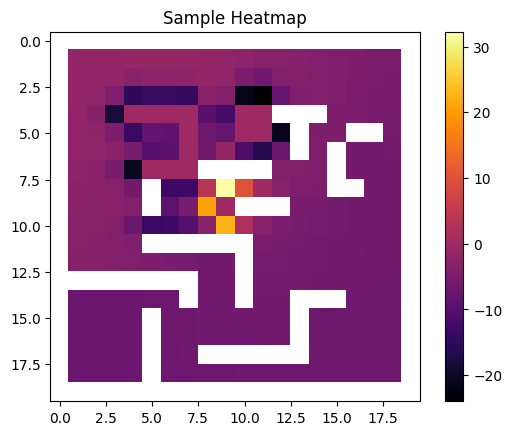

In [24]:
learning_strategy = QLearning()
environment = Environment('salas/salaA.txt', True, display=False)
agent = Agent(x=0, y=0, environment=environment, display=environment.display)
environment.agent = agent
learning_strategy.setup(environment, agent)

learning_strategy.train(10000, exploration_chance=0.5, display=False, appx=False)
#agent.render.show()
print("Done")
print(sum(learning_strategy.time))

Renderer.create_heatmap(learning_strategy.agent.book_V, cmap='inferno', title='Sample Heatmap')

In [ ]:
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.networks import sequential
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents import trajectories
from tf_agents.utils import common
import matplotlib.pyplot as pl
import numpy as np
import tensorflow as tf
import tqdm
import gym
import argparse


# Define a larger map
large_map = [
    'SFFFFFFF',
    'FFFFFFFF',
    'FFFHFFFF',
    'FFFFFFFF',
    'HFFFFFFF',
    'FFFFFFFF',
    'FFFFFFFF',
    'GFFFFFFF'
]


def main():
    parser = argparse.ArgumentParser()
    
    parser.add_argument('--iter', '-i', type=int, default=1000)
    parser.add_argument('--slippery', '-s', type=bool ,action=argparse.BooleanOptionalAction)
    args = parser.parse_args()

    arg_num_iterations = args.iter
    arg_is_slippery = args.slippery if args.slippery is not None else False

    print('Number of iterations: ', arg_num_iterations, "\nIs slippery: ", arg_is_slippery)

    train_env = make_env(arg_is_slippery)
    tf_agent = make_tf_agent(train_env)
    replay_buffer = make_replay_buffer(tf_agent, train_env)
    collect_episodes_per_iteration = 1
    batch_size = 64
    dataset = replay_buffer.as_dataset(
        num_parallel_calls=3, sample_batch_size=batch_size, num_steps=2
    ).prefetch(3)
    iterator = iter(dataset)
    collect_episode(
        train_env,
        tf_agent.collect_policy,
        collect_episodes_per_iteration + batch_size,
        replay_buffer,
    )

    returns = []
    losses = []
    weights = []
    num_iterations = arg_num_iterations
    eval_interval = 50
    num_eval_episodes = 10
    for _ in tqdm.tqdm(range(num_iterations)):
        collect_episode(
            train_env,
            tf_agent.collect_policy,
            collect_episodes_per_iteration,
            replay_buffer,
        )
        experience, unused_info = next(iterator)
        experience2 = trajectory.Trajectory(
            experience.step_type,
            experience.observation,
            experience.action,
            experience.policy_info,
            experience.next_step_type,
            experience.reward,
            experience.discount * 0.95,
        )
        losses.append(tf_agent.train(experience2).loss)
        step = tf_agent.train_step_counter.numpy()
        s  = f"_{arg_num_iterations}_{arg_is_slippery}"
        if step % eval_interval == 0:
            avg_return = compute_avg_return(
                train_env, tf_agent.policy, num_eval_episodes
            )
            returns.append(avg_return)
            weights.append(tf_agent._q_network.layers[0].get_weights())
            
            plot_returns(eval_interval, returns,s)
            plot_loss(losses,s)
            plot_weights(eval_interval, weights,s)
    #view_policy(train_env, tf_agent.policy)
    show_policy_for_each_state(train_env, tf_agent.policy,s)


def make_replay_buffer(tf_agent, train_env):
    replay_buffer_capacity = 100000
    replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=tf_agent.collect_data_spec,
        batch_size=train_env.batch_size,
        max_length=replay_buffer_capacity,
    )
    return replay_buffer


def make_env(is_slippery):
    env_name = "FrozenLake-v1"

    train_gym_env = gym.make(env_name, desc=large_map, is_slippery=is_slippery)
    train_py_env = suite_gym.wrap_env(train_gym_env)
    train_env = tf_py_environment.TFPyEnvironment(train_py_env)

    print("Observation and action:")
    print(train_env.observation_spec())
    print(train_env.action_spec())
    return train_env


def make_tf_agent(train_env):
    dense_layers = [
        tf.keras.layers.Embedding(64, 4),
    ]
    q_net = sequential.Sequential(dense_layers)
    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    train_step_counter = tf.Variable(0)
    tf_agent = dqn_agent.DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        q_network=q_net,
        optimizer=optimizer,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter,
    )
    tf_agent.initialize()
    summarize_network(q_net)
    tf_agent.train = common.function(tf_agent.train)
    tf_agent.train_step_counter.assign(0)
    return tf_agent


def plot_returns(eval_interval, returns, s):
    steps = np.arange(0, len(returns)) * eval_interval
    pl.clf()
    pl.gcf().set_size_inches((7, 7))
    pl.plot(steps, returns, marker="o")
    pl.ylabel("Average Return")
    pl.xlabel("Step")
    pl.tight_layout()
    pl.savefig(f"training{s}.pdf")
    pl.savefig(f"training{s}.png", dpi=150)


def plot_loss(losses,s):
    steps = np.arange(1, len(losses) + 1)
    pl.clf()
    pl.gcf().set_size_inches((7, 7))
    pl.semilogy(steps, losses, marker=".", linestyle="none", alpha=0.5)
    pl.ylabel("Loss")
    pl.xlabel("Steps")
    pl.tight_layout()
    pl.savefig(f"loss{s}.pdf")
    pl.savefig(f"loss{s}.png", dpi=150)


def plot_weights(eval_interval, weights,s):
    pl.clf()
    pl.gcf().set_size_inches((18, 48))
    all_weights = np.stack(weights)
    print(all_weights.shape)
    ylim = np.min(all_weights.flatten()), np.max(all_weights.flatten())
    steps = np.arange(all_weights.shape[0]) * eval_interval
    for row in range(all_weights.shape[2]):
        for col in range(all_weights.shape[3]):
            ax = pl.gcf().add_subplot(
                all_weights.shape[2],
                all_weights.shape[3],
                row * all_weights.shape[3] + col + 1,
            )
            x = steps
            y = all_weights[:, 0, row, col]
            ax.plot(x, y, marker="o")
            ax.grid(True)
            ax.set_ylim(ylim)
    pl.tight_layout()
    pl.savefig(f"weights{s}.pdf")
    pl.savefig(f"weights{s}.png", dpi=150)


def summarize_network(q_net):
    q_net.summary()
    for layer in q_net.layers:
        print(layer)
        print(layer.name)
        if hasattr(layer, "activation"):
            print(layer.activation)
        if hasattr(layer, "layers"):
            for layer in layer.layers[1:]:
                print(layer.name)
                print(layer.activation)


def compute_avg_return(env, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = env.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = env.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]


def collect_episode(env, policy, num_episodes, replay_buffer):
    episode_counter = 0
    env.reset()

    while episode_counter < num_episodes:
        time_step = env.current_time_step()
        action_step = policy.action(time_step)
        next_time_step = env.step(action_step.action)
        traj = trajectory.from_transition(time_step, action_step, next_time_step)

        replay_buffer.add_batch(traj)

        if traj.is_boundary():
            episode_counter += 1
    
def view_policy(env, policy):
    for _ in range(10):
        time_step = env.reset()
        while not time_step.is_last():
            pl.clf()
            env.render()
            pl.gcf().canvas.draw()
            action_step = policy.action(time_step)
            time_step = env.step(action_step.action)
            pl.pause(0.1)

def show_policy_for_each_state(env, policy,s):
    buffer = []
    num_states = env.observation_spec().maximum + 1
    for state in range(num_states):
        time_step = trajectories.time_step.TimeStep(
            step_type=np.array(0, dtype=np.int32),
            reward=np.array(0.0, dtype=np.float32),
            discount=np.array(1.0, dtype=np.float32),
            observation=np.array(state, dtype=np.int32)
        )
        action_step = policy.action(time_step)
        buffer.append(f"State: {state}, Action: {action_step.action.numpy()}")
    open(f"policy{s}.txt", "w").write("\n".join(buffer))




main()

# <b style="color:#009900">Análise do Monte Carlo em ambiente determinístico</b>

O algoritmo Monte Carlo utilizado foi colocado em diversas salas com diferentes parâmetros. 




##  <b style="color:#22BBBB">Sala 1</b>
A figura abaixo mostra a estrutura da primeira sala usada para avaliação do modelo, sendo essa a sala mais simples que foi usada para os experimentos.

![Sala 1](figs/sala%201.png)

Na imagem o objetivo se mostra apresenta em forma de uma moeda e o agente na forma de um alien verde. Além disso, é possível ver os caminhos válidos em preto e as paredes em rosa. Cada caminho válido aqui garante uma recompensa de -1, enquanto o objetivo garante uma recompensa de 100. Movimentos para cima ou para baixo nesse mapa são sempre em direção a uma parede, o que não move o agente do lugar. Assim é esperado que esse tipo de comportamento seja evitado com o passar do tempo. A política é inicializada de forma aleatória e pode ser verificada na forma de setas azuis, como na figura abaixo:

![Politica inicial da sala 1](figs/politicaInicialSala1.png)

Um primeiro obstáculo foi verificado aqui: Como a política inicial pode iniciar direcionando o agente para um local inválido, o mantendo preso para sempre, é necessário definir um valor máximo de passos para cada episódio. Aqui esse valor foi de 10 passos. Ou seja, o episódio acaba quando o agente atinge o estado terminal ou após 10 passos.
Após 10 episódios nesse cenário, o algoritmo não apresentou uma política satisfatória. Porém com 12 episódios houve convergência. O número 12 aqui é curioso pois é múltiplo do número de ações disponíveis (4). E nesse cenário há 3 possíveis locais onde o personagem pode surgir e tomar uma ação válida, já que caso ele surja no estado terminal a simulação acaba o impedindo de tomar uma ação. Assim, 12 é um número suficiente para ele convergir, dado uma probabilidade aleatória, chegando por fim na política ótima abaixo:

![Politica final da sala 1](figs/politicaFinalSala1.png)




##  <b style="color:#22BBBB">Sala 2</b>
A figura abaixo mostra a estrutura da segunda sala usada para avaliação do modelo, uma das salas mais simples presentes, mas que aumenta levemente o número de caminhos válidos disponíveis e possibilita um movimento vertical limitado.

![Sala 2](figs/sala%202.png)

Diferentemente da primeira sala, aqui os movimentos são menos limitados e há mais de um caminho ótimo para o agente descobrir. A política inicial aleatória pode ser vista abaixo:

![Politica inicial da sala 2](figs/politicaInicialSala2.png)

Aqui os 12 episódios não foram suficientes para obter alguma política ótima, e nem era esperado que isso acontecesse, pois o número de movimentos válidos e caminhos aumentou. Observando a imagem é possível verificar que há 7 estados não terminais, nos quais 4 possuem apenas 1 movimento ótimo e 3 com 2 movimentos ótimos (direita ou cima). Assim, há um total de 28 opções totais das quais 10 são ótimas. Isso indica que o agente precisa testar no mínimo 18 opções distintas para encontrar uma política ótima. Treinando o modelo com 18 episódios temos (no melhor resultado):

![Politica da sala 2 com 18 episódios](figs/politicaFinalSala2ep18.png)

Aqui podemos ver que o agente errou em apenas 1 estado a política ótima, porém nesse estado ele fica preso. Além disso, esse resultado não reflete o caso médio, que é bem mais desordenado, mostrando que esse caso foi originado por uma política inicial aleatória muito boa e 18 episódios não são o suficiente para obter uma política adequada para o agente. Já com 36 episódios de treinamento, temos uma política mais estável, mesmo que ainda não ótima no caso médio. É possível vê-la na imagem abaixo:

![Politica da sala 2 com 36 episódios](figs/politicaFinalSala2ep36.png)

 O modelo não conseguiu convergir para a política ótima, porém consegue encontrar um caminho válido. Isso pode ser corrigido com mais episódios ou por alteração do valor do reforço final, uma vez que a adição de um único caminho a mais (reforço somado em -1) não tem muito valor quando comparado com o total ganho no final (100).

Após um processo de busca binária no número de episódios, foi possível encontrar o valor de 130 como um valor em que todas as políticas geradas para 20 amostras foram ótimas.

![Politica final da sala 2](figs/politicaFinalSala2.png)

Em ambientes maiores o algoritmo demora mais para chegar em uma política onde o menor caminho é alcançado, ainda mais quando há diferentes possibilidades de se chegar no objetivo.




##  <b style="color:#22BBBB">Sala 4</b>

Aqui a sala é bem maior mas ainda completamente ampla

![Sala 4](figs/sala%204.png)

Nesse cenário, foi necessário a alteração do limite de passos, uma vez que mesmo com a política ótima, seria impossível que o agente iniciado no canto inferior esquerdo atingisse o estado terminal. Sendo assim ele passou a ser dependente da dimensão do mapa, valendo o número total de quadrados da sala, neste caso 400. Com isso, após 30000 episódios a política convergiu para uma política próxima da ótima:

![Politica final da sala 4](figs/politicaFinalSala4.png)

Aqui é possível verificar que não foram todos os campos com a política boa, mas a adição de mais episódios ao treinamento faz com que o processo seja muito mais longo.




##  <b style="color:#22BBBB">Sala 3</b>

Aqui a sala possui obstáculos no meio do caminho, tornando mais complexa a identificação da política ótima. Além disso, o final do caminho (próximo ao objetivo) é estreito, o que pode dificultar a aprendizagem.

![Sala 3](figs/sala%203.png)

Aqui um resultado peculiar ocorreu:

![Politica final da sala 3](figs/politicaFinalSala3ep100.png)

Foi verificado que a política ótima precisa evoluir a partir do objetivo. O que significa que salas grandes com corredores estreitos podem custar muito para o agente aprender o caminho. Para melhorar o treinamento do agente, foi adicionado a possibilidade dele não seguir a política e experimentar uma nova possibilidade aleatória. Assim ele não fica tão restrito à posição inicial nem à política aleatória inicial. Dessa forma foram necessários 10000 episódios para convergência da política. Mas uma nova característica foi verificada: Com essa taxa de exploração fixa, o agente esquecia da política aprendida em algumas regiões. Para resolver isso, a taxa de exploração passou a decair de acordo com o número de episódios, sendo multiplicada por 0.999 todo final de episódio. Ao final foi produzida a seguinte política:

![Politica final da sala 3](figs/politicaFinalSala3.png)




##  <b style="color:#22BBBB">Salas 5 7 e 8</b>
Mais salas foram adicionadas, aqui a sala 5:

![Sala 5](figs/sala%205.png)

Foram necessários 30000 episódios para atingir a política ótima:

![Politica final da sala 5](figs/politicaFinalSala5.png)

Enquanto para a sala 7:

![Sala 7](figs/sala%207.png)

Nessa sala 30000 episódios geraram a seguinte política:

![Politica final da sala 7](figs/politicaFinalSala7ep30000.png)

Para a última sala, a 8, temos:

![Sala 8](figs/sala%208.png)

O treinamento com 1000 episódios foi bem mais longo em comparação com os demais mapas, isto era esperado já que o limite de passos para cada episódio cresce de acordo com as dimensões do mapa.

![Politica final da sala 8](figs/politicaFinalSala8.png)





# <b style="color:#009900">Análise do Monte Carlo em ambiente estocástico</b>
A estocásticidade do ambiente é dado por um valor racional de 0 a 1 e simboliza a chance de determinada ação trocar para uma outra ação aleatória. Para s = 0.33 significa que há 33% de chance da ação escolhida (ir para a direita por exemplo), trocar para outra ação aleatória (ir para cima por exemplo)

##  <b style="color:#22BBBB">Sala 1</b>

Para uma estocasticidade de 0.1, nenhuma alteração significativa foi percebida, o ambiente se comporta da mesma forma, levando o mesmo número de episódios para convergir para a política ótima. Com o aumento do número de épocas, nenhuma mudança na política foi verificada.

Para um valor de 0.5, em metade das situações a política não conseguiu convergir para a ótima:

![Politica final da sala 1 estocástica](figs/politicaFinalSala1Esto.png)

Para corrigir esse comportamento, a quantidade de episódios aumentou para 100, ainda não sendo o suficiente, e posteriormente para 1000, finalmente convergindo para a política ótima.

Para uma estocasticidade de 0.75, 1000 episódios não foram o suficiente para atingir a política ótima. Nesse ambiente, se em algum momento a política converge para uma direção inválida, esse valor não é alterado, uma vez que a chance de exploração somada a estocasticidade do ambiente fazem com que os movimentos sejam quase totalmente independentes da política, dificultando o aprendizado.

Como esperado, para um valor igual a 1, nenhuma política é derivada do aprendizado, uma vez que não importa a decisão do agente, a ação será completamente aleatória.


##  <b style="color:#22BBBB">Sala 2</b>

A sala 2 foi avaliada com a estocasticidade de 0.1, o que não gerou nenhuma mudança significativa no treinamento do agente. Já para um valor de 0.5, foram necessários 1000 episódios para obter uma política aceitável (com um estado errado ao máximo), e para 0.75 foi necessário 2000 episódios para convergir para a política ótima.

Na sala 3 e estocasticidade 0.1, o modelo foi treinado com 10000 episódios gerando a política abaixo

![Politica final da sala 3 estocástica](figs/politicaFinalSala3sto01e1000.png)

Aqui podemos ver que mesmo com uma estocasticidade baixa, o agente não consegue aprender a política ideal, possivelmente por que para um caminho maior, esse valor se torna bem mais relevante. Para atingir uma qualidade aceitável da política, foram necessários 160000 episódios.
Para estocasticidade de 0.5, o modelo deixou de convergir, encontrando políticas sem sentido mesmo para 320000 episódios

![Politica final da sala 3 estocástica](figs/politicaFinalSala3sto05ep320000.png)





# <b style="color:#009900">Aproximador linear</b>

Para conseguir representar os estados de nosso ambiente, diversas métricas foram testadas, entre elas:
1. Distância do eixo X e Y do agente até o objetivo;
2. Presença de paredes na vizinhança-4
3. Binarização dos estados de entrada

Porém as características que mais deram certo em nosso ambiente foram a variação dos parâmetros em funções como x², xy, y², y³, etc.


# <b style="color:#009900">Métricas</b>


Nessa seção será exposto diversas tabelas com as seguintes métricas: tempo, taxa, recompensa, passos. Tempo se refere a quantidade de tempo em segundos que demorou o treinamento. A taxa se refere à quantidade de pontos iniciais marcados no mapa que obtiveram sucesso (alcançaram o objetivo), dado a política treinada. A recompensa é a média das recompensas finais de cada caminho marcado no mapa. Por fim temos a quantidade de passos do agente até o fim de cada episódio. Todas as métricas foram extraídas a partir dos treinos e testes usando a seed 42. 

As salas usadas para obter as métricas abaixo foram 3.1, 3.2, 5 e A. Sendo elas:

Sala 3.1:

![sala 3.1](figs/sala3.1.png)

Sala 3.2:

![sala 3.1](figs/sala3.2.png)

Sala 5:

![sala 3.1](figs/sala5.png)

Sala A:

![sala 3.1](figs/salaA.png)

##  <b style="color:#22BBBB">Monte Carlo sem aproximador linear e em ambiente determinístico, 1000 episódios</b>

|sala             |tempo (s) |taxa (%) |recompensa|passos |
|-----------------|------|-----|----------|-------|
|3.1|0.111 |100.0|92.35     |7.65   |
|3.2|0.076 |100.0|95.08     |4.92   |
|5  |1.142 |66.66|-74.0    |140.36 |
|A |0.79 |37.5|-221.0     |256.75  |

Aqui é possível verificar que o modelo consegue aprender com 1000 episódios muito bem as salas pequenas ou muito simples, como as salas 1,2,3.1,3.2 4 e 6, além de salas completamente vazias. Ao mesmo tempo, a sala 3 levou mais tempo para ser aprendida, como já discutido nas seções anteriores.


##  <b style="color:#22BBBB">Monte Carlo sem aproximador linear e em ambiente determinístico, 10000 episódios</b>

|sala             |tempo (s)  |taxa (%) |recompensa|passos |
|-----------------|-------|-----|----------|-------|
|3.1|0.823  |100.0|92.7      |7.3    |
|3.2|0.521  |100.0|95.42     |4.58   |
|5  |9.218  |35.71|-224.19   |259.26 |
|A |4.353  |87.5|16.0     |66.875   |


Aqui é possível verificar uma melhora considerável com o aumento dos episódios, mas salas grandes ainda não possuem uma taxa aceitável. A sala 3 ainda não convergiu para uma política boa, possivelmente por conta da taxa de exploração zerada, o que obriga o caminho a iniciar com as escolhas em uma posição ao lado da pré calculada, o que diminui muito a velocidade de convergência.

##  <b style="color:#22BBBB">Monte Carlo sem aproximador linear e em ambiente determinístico, 100000 episódios</b>

|sala|tempo (s)   |taxa (%) |recompensa|passos |
|----|--------|-----|----------|-------|
|3.1|8.976   |100.0|92.7      |7.3    |
|3.2|6.324   |100.0|95.42     |4.58   |
|5  |39.406  |100.33|87.3      |12.61   |
|A |38.189 |100.0|87.3     |12.61   |

Aqui podemos verificar o ganho de eficiência do algoritmo com o aumento do número de episódios, porém houve o aumento do custo computacional. O valor de 10000 episódios apresenta um bom custo benefício e será mantido para os outros testes.
Para a sala 3, a taxa de sucesso está baixa, isso deve aumentar com a taxa de exploração.

##  <b style="color:#22BBBB">Monte Carlo sem aproximador linear e em ambiente estocástico, 0.1 , 10000 episódios</b>


|sala             |tempo (s)   |taxa (%) |recompensa|passos |
|-----------------|--------|-----|----------|-------|
|3.1|0.778   |100.0|92.26     |7.74   |
|3.2|0.565   |100.0|94.29     |5.71   |
|5  |7.895   |100.0|87.3   |174.31 |
|A |7.04   |100.0|79.27     |322.25 |

O ambiente estocástico de 0.1 não foi suficiente para diminuir a qualidade do modelo nas salas 9, 10, 11 e 12.

##  <b style="color:#22BBBB">Monte Carlo sem aproximador linear e em ambiente estocástico, 0.5 , 10000 episódios</b>

|sala             |tempo (s)   |taxa (%) |recompensa|passos |
|-----------------|--------|-----|----------|-------|
|3.1|4.015   |100.0|80.61     |19.39  |
|3.2|1.061   |100.0|91.25     |8.75   |
|5  |7.088   |100.0|79.26    |162.43 |
|A |8.63 |83.33|77.57     |352.88   |


##  <b style="color:#22BBBB">Monte Carlo sem aproximador e em ambiente estocástico, 0.7 , 10000 episódios</b>

|sala             |tempo (s)   |taxa (%) |recompensa|passos |
|-----------------|--------|-----|----------|-------|
|3.1|2.992   |78.26|30.04     |48.0   |
|3.2|1.649   |100.0|79.54     |20.46  |
|5  |11.378  |57.14|-168.4    |225.12 |
|A |8.764 |37.5|-289.25     |276.12   |


Para simplificar os experimentos, vamos apenas mostrar os resultados que destoam do padrão apresentado aqui, que valham a pena serem analisados.

##  <b style="color:#22BBBB">Monte Carlo sem aproximador linear e em ambiente determinístico, com chance de exploração 0.3, 10000 episódios</b>

|sala             |tempo (s) |taxa (%) |recompensa|passos |
|-----------------|------|-----|----------|-------|
|3.1|0.749 |100.0|92.7      |7.3    |
|3.2|0.536 |100.0|95.42     |4.58   |
|5  |1.404 |100.0|87.29     |12.71  |
|A |2.505 |75.0|-42.0     |113.38   |

##  <b style="color:#22BBBB">Monte Carlo sem aproximador linear e em ambiente determinístico, com chance de exploração 0.5, 10000 episódios</b>


|sala             |tempo (s) |taxa (%) |recompensa|passos |
|-----------------|------|-----|----------|-------|
|3.1|0.99  |100.0|92.7      |7.3    |
|3.2|0.681 |100.0|95.42     |4.58   |
|5  |2.118 |95.24|64.5      |30.69  |
|A |2.934 |50.0|-159.88     |208.25   |

##  <b style="color:#22BBBB">Monte Carlo com aproximador linear e em ambiente determinístico, com chance de exploração 0.3, 10000 episódios</b>

|sala             |tempo (s) |taxa (%) |recompensa|passos |
|-----------------|------|-----|----------|-------|
|3.1|7.881 |100.0|92.7      |7.3    |
|3.2|11.568|8.33 |-84.5     |91.92  |
|5  |32.211|2.38 |-389.1    |390.5  |
|A |5.649 |12.5|-339.75     |351.38   |

##  <b style="color:#22BBBB">Sarsa sem aproximador linear e em ambiente estocástico 0.5, com chance de exploração 0.3, 10000 episódios</b>



|sala             |tempo (s) |taxa (%) |recompensa|passos |
|-----------------|------|-----|----------|-------|
|3.1|4.352 |100.0|83.91     |16.09  |
|3.2|1.699 |100.0|91.21     |8.79   |
|5  |109.771|76.19|-65.76    |141.71 |
|A |91.132 |50.0|-259.62     |256.88   |

##  <b style="color:#22BBBB">Sarsa com aproximador linear e em ambiente estocástico 0.5, com chance de exploração 0.3, 1000 episódios</b>

|sala             |tempo (s) |taxa (%) |recompensa|passos |
|-----------------|------|-----|----------|-------|
|3.1|8.192 |39.13|-36.43    |74.96  |
|3.2|11.044|45.83|-23.04    |68.33  |
|5  |116.541|9.52 |-353.88   |362.5  |
|A |68.112 |50.0|-379.0     |328.5   |

##  <b style="color:#22BBBB">Q-Learning sem aproximador linear e em ambiente estocástico 0.5, com chance de exploração 0.3, 10000 episódios</b>

|sala             |tempo (s)|taxa (%) |recompensa|passos|
|-----------------|-----|-----|----------|------|
|3.1|1.9  |100.0|83.78     |16.22 |
|3.2|1.025|100.0|90.17     |9.83  |
|5  |11.829|64.29|-128.6    |192.52|
|A |10.448 |75.0|-167.88     |188.12   |


##  <b style="color:#22BBBB">Q-Learning com aproximador linear e em ambiente estocástico 0.5, com chance de exploração 0.3, 10000 episódios</b>

|sala             |tempo (s)|taxa (%) |recompensa|passos|
|-----------------|-----|-----|----------|------|
|3.1|1.545|65.22|12.39     |52.48 |
|3.2|2.067|37.5 |-39.29    |76.17 |
|5  |9.706|7.14 |-365.52   |371.74|
|A |62.505 |12.5|-375.0     |361.62   |

É importante ressaltar que nenhum modelo performou bem na sala 8, a maior sala disponível, uma vez que não foi possível apresentar todos os estados para os modelos.



Como forma de verificar a recompensa dos algoritmos com o passar do tempo, foi construída uma sala genérica com diversos reforços positivos e negativos, vários estados finais e um tamanho grande o suficiente para explorar o "medo" do agente e estruturas de corredores.

O treinamento ocorreu com uma chance de exploração 0.3, estratégia do Monte Carlo em um ambiente com estocasticidade 0.1. Vale lembrar que o custo da lava é -100 sendo um estado terminal e o ácido com custo de -10, não sendo um estado terminal.

![Sala A](figs/salaA.png)

Após o treinamento, temos a política final:

![Politica final da sala A estocástica](figs/politicaFinalSalaAsto01ep50000.png)

O treinamento levou 14 segundos e a recompensa média foi de 70, com média de 24 passos.

O gráfico abaixo apresenta a curva de aprendizagem do algoritmo dado a configuração descrita acima:

![Recompensa no tempo Monte Carlo](figs/reward/rewardSalaAep50000.png)

Aqui é possível verificar que o modelo convergiu rapidamente para a política ótima. Vale ressaltar que o gráfico foi construído através de uma média móvel de 10% das amostras, ou seja, 5000 amostras.


Um resultado estranho foi encontrado para o Sarsa: O treinamento atinge um máximo e decai rapidamente perdendo informação:

![Recompensa no tempoSarsa ](figs/reward/rewardSalaAep50000Sarsa.png)


A política final nesse caso é 

![Recompensa no tempoSarsa ](figs/Sarsa50000.png)


Treinando por 10000 episódios temos:


![Recompensa no tempoSarsa ](figs/reward/rewardSalaAep10000Sarsa.png)

E o resultado da política:

![Recompensa no tempoSarsa ](figs/Sarsa10000.png)


Analisando agora o parametro lambda para o Sarsa, ele será variado de 0.01, 0.1 e 0.5, com 10000 episódios cada.
Essa quantidade de episódios foi escolhida por que o modelo sofre de overflow caso o número de episódios seja muito grande para lambda = 0.5.

para lambda = 0.01, temos:
![Recompensa no tempoSarsa ](figs/reward/Sarsa001.png)

para lambda = 0.1, temos:
![Recompensa no tempoSarsa ](figs/reward/Sarsa01.png)

para lambda = 0.5, temos:
![Recompensa no tempoSarsa ](figs/reward/Sarsa05.png)

Podemos verficar que quanto maior o valor de lambda, mais rapidamente o modelo converge para a política ótima, mas é necessário balancear esse valor com o número de episódios, uma vez que o modelo pode sofrer overflow e convergir para uma política em que todos os estados tem valores infinitos.

|lambda             |tempo |taxa |recompensa|passos |
|-----------------|------|-----|----------|-------|
|0.01  |213.78  |37.5|-333.62     |295.5    |
|0.1  |209.73 |100.0|-370.37     |295.5   |
|0.5  |126.73 |87.5|-118.25    |119.625   |


Analisando agora os valores dos estados para 6 configurações de algoritmos, temos:

Monte Carlo sem aproximador linear, 10000 episódios, chance de exploração 0.5

![Valores dos estados para o Monte Carlo](figs/AmonteCarlo.png)

Monte Carlo com aproximador linear, 10000 episódios, chance de exploração 0.5

![Valores dos estados para o Monte Carlo](figs/AmonteCarloAprox.png)

Sarsa sem aproximador linear, 10000 episódios, chance de exploração 0.5, lambda 0.5

![Valores dos estados para o Sarsa](figs/ASarsa.png)

Sarsa com aproximador linear, 10000 episódios, chance de exploração 0.5, lambda 0.5

![Valores dos estados para o Sarsa](figs/ASarsaAprox.png)

Q-Learning sem aproximador linear, 10000 episódios, chance de exploração 0.5

![Valores dos estados para o Q-Learning](figs/AQLearning.png)

Q-Learning com aproximador linear, 10000 episódios, chance de exploração 0.5

![Valores dos estados para o Q-Learning](figs/AQLearningAprox.png)




# <b style="color:#009900">DQN</b>

A DQN substitui a necessidade de usar tabelas para calcular o valor de Q e V, e diferentemente do aproximador linear, consegue aprender funções não-lineares para representar seu conhecimento. Infelizmente não houve tempo hábil para reimplementar ou adaptar o nosso ambiente usado até então em nossos testes. Por isso foi buscado um ambiente no [gymlibrary](https://www.gymlibrary.dev) mais análogo possível ao nosso. 

Optamos pelos [Frozen Lake](https://www.gymlibrary.dev/environments/toy_text/frozen_lake/). Nele o agente pode se mover nas quatros direções cardeais. Há dois estados terminais, os buracos com recompensa 0, e o objetivo final com recompensa 1. A estocasticidade pode ser habilitada para que haja ⅓ de chance do agente não se mover na direção escolhida pela política, e “deslizar” para outro estado. A escolha desse ambiente foi interessante, pois assim também mudamos a função de recompensa, podendo ser observado nos resultado sua influência na hora de resolver o problema.

A DQN foi treinada em um mapa 8x8, variando a quantidade de episódios [100, 1000, 10000], com e sem estocasticidade. Os gráficos abaixo representam a curva de aprendizado dos algoritmos com 1000 e 10000 episódios. Com apenas 100 episódios a DQN não foi capaz de aprender nada em nenhum dos casos. Já com 1000 episódios a curva começa a ficar interessante para o caso estocástico, porém ainda muito provavelmente influenciado pela natureza aleatória do ambiente. Com 10000 episódios é possível ver que o algoritmo conseguiu convergir muito antes. Para a mesma quantidade de episódios no mundo estocástico, o algoritmo convergiu cedo, porém devido a aleatoriedade, ele oscilou bastante em aprender e desaprender a sua política.

Gráfico de aprendizagem DQN com 1000 episódios e sem estocasticidade:

![Gráfico de aprendizagem DQN com 1000 episódios e sem estocasticidade](dqn_results/training_1000_False.png)
Gráfico de aprendizagem DQN com 1000 episódios e sem estocasticidade


Gráfico de aprendizagem DQN com 1000 episódios e com estocasticidade:
![Gráfico de aprendizagem DQN com 1000 episódios e com estocasticidade](dqn_results/training_1000_True.png)


Gráfico de aprendizagem DQN com 10000 episódios e sem estocasticidade:
![Gráfico de aprendizagem DQN com 10000 episódios e sem estocasticidade](dqn_results/training_10000_False.png)


Gráfico de aprendizagem DQN com 10000 episódios e com estocasticidade:
![Gráfico de aprendizagem DQN com 10000 episódios e com estocasticidade](dqn_results/training_10000_True.png)

Por fim temos a ilustração da política final obtida durante o treinamento. Primeiramente a política do ambiente determinístico, onde temos que todos os caminhos levam para o objetivo final. Porém, diferentemente da política derivada pelos demais algoritmos no ambiente anterior, a falta de um desconto temporal fez com que não fosse uma preocupação encontrar o menor caminho até o objetivo.

![Gráfico de aprendizagem DQN com 10000 episódios e com estocasticidade](dqn_results/10000_politica_False.jpeg)

Já no caso estocástico, observamos um comportamento parecido com os demais algoritmos, onde o agente aprender a ter “medo” de passar perto dos estados terminais que não dão uma recompensa negativa.

![Gráfico de aprendizagem DQN com 10000 episódios e com estocasticidade](dqn_results/10000_politica_True.jpeg)
